In [3]:
!pip install torchaudio

  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/113.7 MB ? eta -:--:--
    --------------------------------------- 2.1/113.7 MB 10.7 MB/s eta 0:00:11
    --------------------------------------- 2.6/113.7 MB 10.0 MB/s eta 0:00:12
   - -------------------------------------- 3.9/113.7 MB 6.2 MB/s eta 0:00:18
   - -------------------------------------- 4.5/113.7 MB 5.4 MB/s eta 0:00:21
   - -------------------------------------- 5.0/113.7 MB 4.6 MB/s eta 0:00:24
   - -------------------------------------- 5.2/113.7 MB 4.4 MB/s eta 0:00:25
   -- ------------------------------------- 5.8/113.7 MB 4.0 MB/s eta 0:00:28
   -- ------------------------------------- 6.0/113.7 MB 3.7 MB/s eta 0:00:29
   -- ------------------------------------- 6.6/113.7 MB 3.5 MB/s eta 0:00:31
   --- ------------------------------------ 8.7/113.7 MB 4.1 MB/s eta 0:00:26
   --- ------------------------------------ 11.0/113.7 MB 4.7 MB/s eta 0:00:22
   ---

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.20.1 requires torch==2.5.1, but you have torch 2.10.0 which is incompatible.


In [1]:
import os
import librosa
import pandas as pd
import shutil
import numpy as np
import soundfile as sf
from glob import glob
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
import torch
import torchaudio
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchaudio.transforms as T
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [3]:
sounds_df = pd.read_csv('data/UrbanSound8K/UrbanSound8K.csv')
sounds_df[sounds_df['classID'] == 0]

,slice_file_name,fsID,start,end,salience,fold,classID,class
22,100852-0-0-0.wav,100852,0.0,4.0,1,5,0,air_conditioner
23,100852-0-0-1.wav,100852,0.5,4.5,1,5,0,air_conditioner
24,100852-0-0-10.wav,100852,5.0,9.0,1,5,0,air_conditioner
25,100852-0-0-11.wav,100852,5.5,9.5,1,5,0,air_conditioner
26,100852-0-0-12.wav,100852,6.0,10.0,1,5,0,air_conditioner
...,...,...,...,...,...,...,...,...
8307,85569-0-0-5.wav,85569,2.5,6.5,1,5,0,air_conditioner
8308,85569-0-0-6.wav,85569,3.0,7.0,1,5,0,air_conditioner
8309,85569-0-0-7.wav,85569,3.5,7.5,1,5,0,air_conditioner
8310,85569-0-0-8.wav,85569,4.0,8.0,1,5,0,air_conditioner


In [4]:
classes = {
    0: 'air_conditioner',
    1: 'car_horn',
    2: 'children_playing',
    3: 'dog_bark',
    4: 'drilling',
    5: 'engine_idling',
    6: 'gun_shot',
    7: 'jackhammer',
    8: 'siren',
    9: 'street_music',
}

In [5]:
# распределение по классам
source_dir = 'data/UrbanSound8K/'
output_dir = 'data/audio/'

os.makedirs(output_dir, exist_ok=True)

folders = [f'fold{i}' for i in range(1, 11)]

for folder in folders:
    folder_path = os.path.join(source_dir, folder)
    os.makedirs(folder_path, exist_ok=True)
    for filename in os.listdir(os.path.join(source_dir, folder)):
        if filename.endswith(".wav"):
            parts = filename.replace('.wav', '').split('-')

            if len(parts) >= 2:
                class_number = parts[1]

                class_dir = os.path.join(output_dir, f'class_{class_number}')
                os.makedirs(class_dir, exist_ok=True)

                src = os.path.join(folder_path, filename)
                dst = os.path.join(class_dir, filename)
                shutil.copy2(src, dst)

In [6]:
# обрезка полезного сигнала (удаление тишины)
def remove_silence(y, sr, top_db=25, hop_lenght=512):
    # ссигнал выше порога
    intervals = librosa.effects.split(y, top_db=top_db, hop_length=hop_lenght)
    # склейка фрагментов
    y_clean = np.concatenate([y[start:end] for start, end in intervals])
    return y_clean

path = output_dir

for fold in glob(os.path.join(path, 'class_*')):
    print(f'process folder {fold}') # debug
    for fpath in glob(os.path.join(fold, '*.wav')):
        y, sr = librosa.load(fpath, sr=None)
        y_clean = remove_silence(y, sr)

process folder data/audio\class_0
process folder data/audio\class_1
process folder data/audio\class_2
process folder data/audio\class_3
process folder data/audio\class_4
process folder data/audio\class_5
process folder data/audio\class_6
process folder data/audio\class_7
process folder data/audio\class_8
process folder data/audio\class_9


In [7]:
# проверка распределения по классам
class_counts ={}

for class_folder in os.listdir(output_dir):
    class_path = os.path.join(output_dir, class_folder)
    count = len([f for f in os.listdir(class_path)])
    class_counts[class_folder] = count

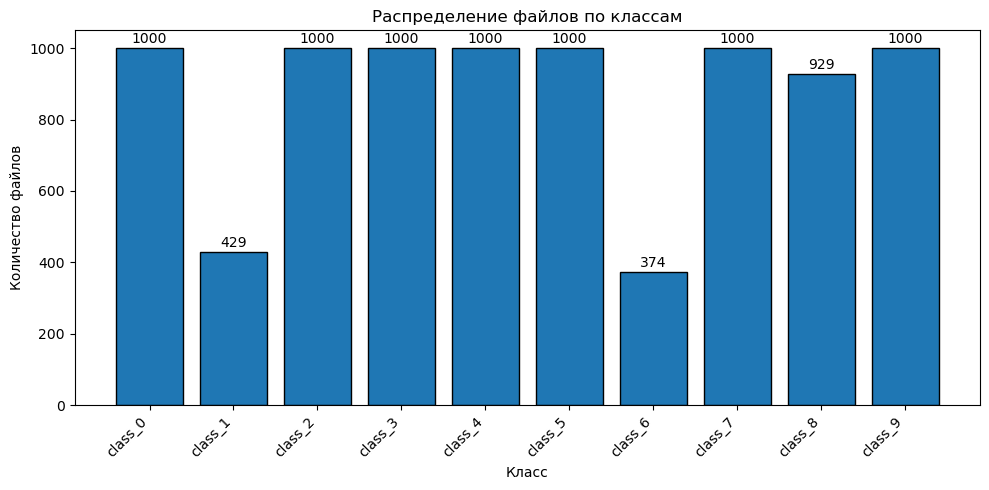

In [8]:
classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(10, 5))
bars = plt.bar(classes, counts, edgecolor='black')

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             str(count), ha='center', va='bottom', fontsize=10)

plt.xlabel("Класс")
plt.ylabel("Количество файлов")
plt.title("Распределение файлов по классам")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

In [9]:
classcounts = {}
for class_folder in os.listdir('data/audio'):
    class_path = os.path.join('data/audio', class_folder)
    classcounts[class_folder] = len([f for f in os.listdir(class_path) if f.endswith('.wav')])
print(classcounts)

{'class_0': 1000, 'class_1': 429, 'class_2': 1000, 'class_3': 1000, 'class_4': 1000, 'class_5': 1000, 'class_6': 374, 'class_7': 1000, 'class_8': 929, 'class_9': 1000}


In [10]:
max_count = max(classcounts.values())
print(f"Макс. сэмплов: {max_count}")

Макс. сэмплов: 1000


In [11]:
def augment_audio(file_path, class_folder, output_dir, n_augs):
    y, sr = librosa.load(file_path, sr=22050)
    aug_paths = []
    for i in range(n_augs):
        # Pitch shift
        y_pitch = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.uniform(-4, 4))
        # Time stretch
        y_stretch = librosa.effects.time_stretch(y_pitch, rate=1 + np.random.uniform(-0.2, 0.2))
        # Add noise
        noise = np.random.randn(len(y_stretch))
        y_aug = y_stretch + 0.005 * noise
        aug_file = os.path.join(output_dir, f"{os.path.basename(file_path).split('.')[0]}_aug{i}.wav")
        sf.write(aug_file, y_aug, sr)
        aug_paths.append(aug_file)
    return aug_paths

target_dir = 'data/audio_balanced'
os.makedirs(target_dir, exist_ok=True)

for class_folder, count in classcounts.items():
    class_path = os.path.join('data/audio', class_folder)
    class_out = os.path.join(target_dir, class_folder)
    os.makedirs(class_out, exist_ok=True)

    files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith('.wav')]
    n_needed = max_count - count
    n_augs_per_file = max(1, n_needed // len(files) + 1)

    for file in files:
        augment_audio(file, class_folder, class_out, n_augs_per_file)

D:\Python\Anaconda\anaconda3\envs\Python_3_10\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
D:\Python\Anaconda\anaconda3\envs\Python_3_10\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
D:\Python\Anaconda\anaconda3\envs\Python_3_10\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [12]:
class UrbanSoundDataset(Dataset):
    def __init__(self, file_list, class_to_id, sr=22050, n_mfcc=40, fixed_length=100):
        self.file_list = file_list
        self.class_to_id = class_to_id
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.fixed_length = fixed_length

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        path, label = self.file_list[idx]

        # Загрузка
        waveform, sr = librosa.load(path, sr=self.sr)

        # Fixed length 4 sec
        target_length = self.sr * 4
        if len(waveform) > target_length:
            waveform = waveform[:target_length]
        else:
            waveform = np.pad(waveform, (0, target_length - len(waveform)))

        # MFCC: (n_mfcc=40, time)
        mfcc = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=self.n_mfcc)

        # Fixed time (padding/cropping по оси времени)
        if mfcc.shape[1] > self.fixed_length:
            mfcc = mfcc[:, :self.fixed_length]
        else:
            pad_width = self.fixed_length - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')

        # ВАЖНО для Conv1D: (B, C, L), где C = n_mfcc (40), L = time (100)
        mfcc_tensor = torch.from_numpy(mfcc).float()  # (40, 100)

        return mfcc_tensor, torch.tensor(label, dtype=torch.long)


In [13]:
# С пулингом (input: CxL = 40x100)
class Conv1DWithPool(nn.Module):
    def __init__(self, num_classes=10, n_mfcc=40, fixed_length=100):
        super().__init__()
        self.conv1 = nn.Conv1d(n_mfcc, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)

        # L=100 -> pool -> 50 -> pool -> 25
        self.fc1 = nn.Linear(64 * (fixed_length // 4), 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x: (B, 40, 100)
        x = torch.relu(self.conv1(x))  # (B, 32, 100)
        x = self.pool(x)               # (B, 32, 50)
        x = torch.relu(self.conv2(x))  # (B, 64, 50)
        x = self.pool(x)               # (B, 64, 25)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [14]:
# Без пулинга
class Conv1DNoPool(nn.Module):
    def __init__(self, num_classes=10, n_mfcc=40, fixed_length=100):
        super().__init__()
        self.conv1 = nn.Conv1d(n_mfcc, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)

        # L остаётся 100
        self.fc1 = nn.Linear(64 * fixed_length, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x: (B, 40, 100)
        x = torch.relu(self.conv1(x))  # (B, 32, 100)
        x = torch.relu(self.conv2(x))  # (B, 64, 100)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [15]:
def scan_dataset(root_dir):
    file_list = []
    classcounts = {}
    classes = []

    for class_folder in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_folder)
        if os.path.isdir(class_path):
            files = [f for f in os.listdir(class_path) if f.endswith('.wav')]
            classcounts[class_folder] = len(files)
            class_id = len(classes)
            classes.append(class_folder)
            for fname in files:
                file_list.append((os.path.join(class_path, fname), class_id))
    return file_list, classes, classcounts

file_list, classes, classcounts = scan_dataset('data/audio_balanced')
class_to_id = {cls: i for i, cls in enumerate(classes)}
id_to_class = {i: cls for i, cls in enumerate(classes)}

print("Классы:", classes)
print("Распределение:", classcounts)

train_files, test_files = train_test_split(file_list, test_size=0.2, stratify=[label for _, label in file_list])

train_dataset = UrbanSoundDataset(train_files, class_to_id)
test_dataset = UrbanSoundDataset(test_files, class_to_id)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Классы: ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9']
Распределение: {'class_0': 1000, 'class_1': 858, 'class_2': 1000, 'class_3': 1000, 'class_4': 1000, 'class_5': 1000, 'class_6': 748, 'class_7': 1000, 'class_8': 929, 'class_9': 1000}


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [17]:
def train_model(model, train_loader, test_loader, epochs=20, lr=0.001):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, train_accs = [], []
    val_accs = []

    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for mfcc_batch, labels in train_loader:
            mfcc_batch, labels = mfcc_batch.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(mfcc_batch)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for mfcc_batch, labels in test_loader:
                mfcc_batch, labels = mfcc_batch.to(device), labels.to(device)
                outputs = model(mfcc_batch)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        val_acc = 100 * correct_val / total_val

        train_losses.append(epoch_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1:2d}: Loss={epoch_loss:.4f}, Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%')

    return train_losses, train_accs, val_accs

In [18]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for mfcc_batch, labels in test_loader:
            mfcc_batch, labels = mfcc_batch.to(device), labels.to(device)
            outputs = model(mfcc_batch)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"\nAccuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    return acc, all_preds, all_labels

=== Обучение модели С ПУЛИНГОМ ===
Epoch  1: Loss=1.9834, Train Acc=31.37%, Val Acc=44.42%
Epoch  2: Loss=1.5323, Train Acc=46.19%, Val Acc=48.09%
Epoch  3: Loss=1.3770, Train Acc=52.33%, Val Acc=57.58%
Epoch  4: Loss=1.2811, Train Acc=55.86%, Val Acc=56.21%
Epoch  5: Loss=1.1936, Train Acc=58.63%, Val Acc=59.15%
Epoch  6: Loss=1.0907, Train Acc=61.77%, Val Acc=64.29%
Epoch  7: Loss=1.0408, Train Acc=63.66%, Val Acc=64.13%
Epoch  8: Loss=0.9865, Train Acc=65.84%, Val Acc=66.18%
Epoch  9: Loss=0.9207, Train Acc=68.10%, Val Acc=67.02%
Epoch 10: Loss=0.8699, Train Acc=70.14%, Val Acc=67.86%
Epoch 11: Loss=0.8324, Train Acc=71.22%, Val Acc=67.33%
Epoch 12: Loss=0.7929, Train Acc=71.96%, Val Acc=67.02%
Epoch 13: Loss=0.7488, Train Acc=73.83%, Val Acc=66.18%
Epoch 14: Loss=0.7165, Train Acc=75.28%, Val Acc=68.01%
Epoch 15: Loss=0.6451, Train Acc=77.08%, Val Acc=68.90%

=== Обучение модели БЕЗ ПУЛИНГА ===
Epoch  1: Loss=2.4717, Train Acc=26.49%, Val Acc=42.21%
Epoch  2: Loss=1.6273, Train Acc

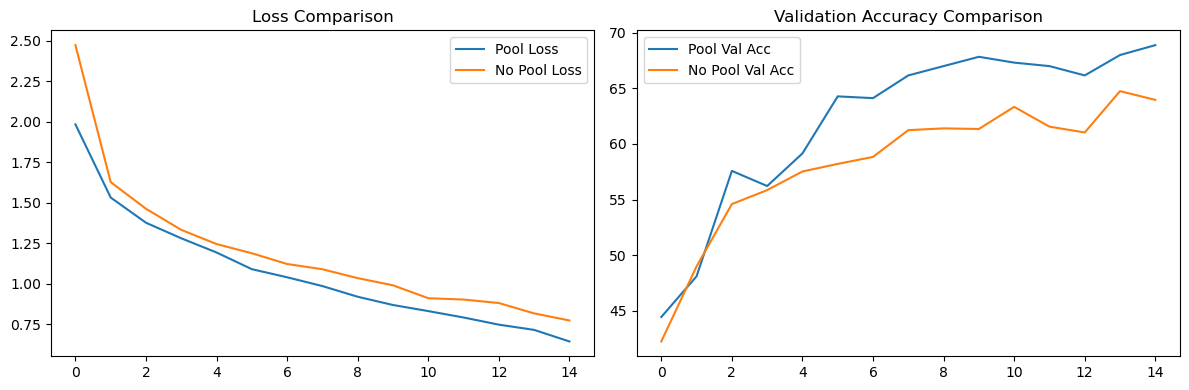


ИТОГ: Pool=68.9% vs NoPool=64.0%


In [20]:
# Создаём модели
model_pool = Conv1DWithPool(num_classes=10, n_mfcc=40, fixed_length=100)
model_nopool = Conv1DNoPool(num_classes=10, n_mfcc=40, fixed_length=100)

print("=== Обучение модели С ПУЛИНГОМ ===")
pool_losses, pool_train_accs, pool_val_accs = train_model(model_pool, train_loader, test_loader, epochs=15)

print("\n=== Обучение модели БЕЗ ПУЛИНГА ===")
nopool_losses, nopool_train_accs, nopool_val_accs = train_model(model_nopool, train_loader, test_loader, epochs=15)

# Финальная оценка
print("\n" + "="*50)
print("ФИНАЛЬНАЯ ОЦЕНКА")
print("="*50)

print("\n1. МОДЕЛЬ С ПУЛИНГОМ:")
pool_acc, _, _ = evaluate_model(model_pool, test_loader)

print("\n2. МОДЕЛЬ БЕЗ ПУЛИНГА:")
nopool_acc, _, _ = evaluate_model(model_nopool, test_loader)

# График сравнения
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(pool_losses, label='Pool Loss')
plt.plot(nopool_losses, label='No Pool Loss')
plt.title('Loss Comparison')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(pool_val_accs, label='Pool Val Acc')
plt.plot(nopool_val_accs, label='No Pool Val Acc')
plt.title('Validation Accuracy Comparison')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nИТОГ: Pool={pool_acc:.1%} vs NoPool={nopool_acc:.1%}")
